# Testis 1 Forced 3k Cell Cycle

In [50]:
import os
import sys
from pathlib import Path
from collections import defaultdict
import re
from tempfile import NamedTemporaryFile
from IPython.display import display, HTML, Markdown, Image
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from goatools.obo_parser import GODag
from goatools.go_search import GoSearch
from goatools.godag_plot import plot_gos

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-16_testis1_force_cell_cycle', seurat_dir='../output/testis1_scRNAseq_3k/')

last updated: 2018-03-16 
Git hash: b4607e6f1d22f5de926471c9887f399587814dd0


# Get list of Cell Cycle Genes

In [6]:
obo = '../data/external/go-basic.obo'
oboDag = GODag(obo)

# Import fly associations
association = '../data/external/gene_association.fb'
fly = defaultdict(set)
with open(association) as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        #if gtype != 'protein':
        #    continue
        if goterm not in oboDag:
            continue
        fly[fbgn].add(goterm)

# Convert from fly2go to go2fly
go2fly = defaultdict(set)
for k, v in fly.items():
    for t in v:
        if oboDag[t].namespace != 'biological_process':
            continue
            
        go2fly[t].add(k)
        
# Init searcher
searcher = GoSearch(obo, go2fly)

load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms
load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms


In [8]:
# Search for cell cycle
cell_cycle_all = re.compile(r'cell cycle', flags=re.IGNORECASE)
cell_cycle_not = re.compile(r'cell cycle.independent', flags=re.IGNORECASE)

tmp = NamedTemporaryFile()
with open(tmp.name, 'w') as log:
    
    # find gos matching cell cycle
    gos_cc_all = searcher.get_matching_gos(cell_cycle_all, prt=log)
    
    # Find any GOs matching 'cell cycle-independent' (e.g., "lysosome")
    gos_no_cc = searcher.get_matching_gos(cell_cycle_not, gos=gos_cc_all, prt=log)
    
    # Remove GO terms that are not "cell cycle" GOs
    gos = gos_cc_all.difference(gos_no_cc)
    
    # Add children GOs of cell cycle GOs
    gos_all = searcher.add_children_gos(gos)
    
    # Only focus on biological process
    keepers = set()
    for go in gos_all:
        if oboDag[go].namespace == 'biological_process':
            keepers.add(go)
            
    cell_cycle_geneids = searcher.get_items(keepers)
    
tmp.close()

In [9]:
len(cell_cycle_geneids)

992

  483 usr 1080 GOs  WROTE: /data/fearjm/Projects/larval_gonad/notebook/../output/figures/2018-03-16_testis1_force_cell_cycle_cell_cycle_go.png


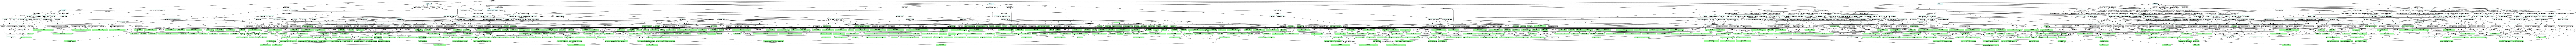

In [64]:
_png = nbconfig.fig_name('cell_cycle_go.png')
fig = plt.figure(figsize=(20, 10), dpi=200)
plot_gos(_png, gos_all, oboDag)

Image(_png)

In [63]:
gos_all = searcher.add_children_gos({'GO:0022402'})

In [66]:
searcher.get_items(searcher.add_children_gos({'GO:0044839'}))

{'FBgn0000405',
 'FBgn0002673',
 'FBgn0003525',
 'FBgn0003731',
 'FBgn0004106',
 'FBgn0004107',
 'FBgn0005672',
 'FBgn0011206',
 'FBgn0011207',
 'FBgn0029835',
 'FBgn0035166',
 'FBgn0040298'}

## Get Seurat results

In [10]:
clusters = nbconfig.seurat.get_clusters()

In [11]:
tsne = nbconfig.seurat.get_tsne()

In [17]:
dat = tsne.join(clusters)

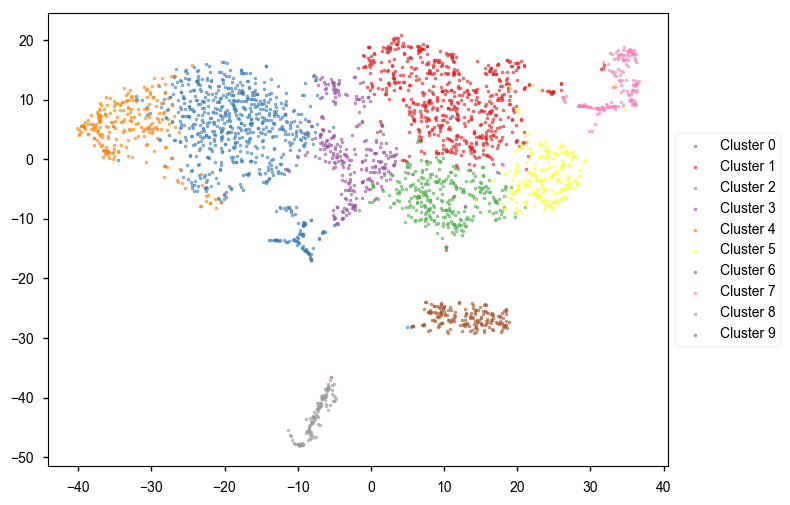

In [40]:
fig, ax = plt.subplots(1, 1, dpi=100)
for i, _df in dat.groupby('res.0.6'):
    ax.scatter(_df.tSNE_1, _df.tSNE_2, s=5, label=f'Cluster {i}', alpha=0.6)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))